# Travelling Salesman Problem

This is an homework of Artificial inteligence.

The homework is to code the travelling salesman problem using genetic algorithm.

Group:
- Hendy Rodrigues F. Silva

Id: 1510081

**Homework by Professor Aragão Junior**




### Definitions and auxiliar variables

In [1]:
import numpy as np
import random
from random import *
import matplotlib.pyplot as plt

coord_x_file = open("data/x.txt","r")
coord_y_file = open("data/y.txt","r")

coord_x = coord_x_file.readlines()
coord_x = list(map(lambda x: int(x.strip()) ,coord_x))

coord_y = coord_y_file.readlines()
coord_y = list(map(lambda y: int(y.strip()) ,coord_y))

cities = list(zip(coord_x, coord_y))

amount_select = 8 # deve ser divisivel por 4

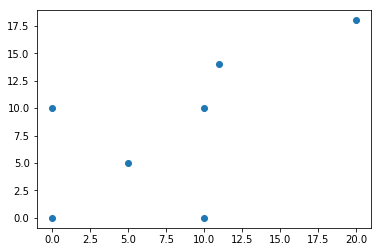

In [2]:
plt.scatter(coord_x, coord_y)

### Auxiliar functions

In [3]:
def euclidian(city_from, city_to):
    return np.sqrt((city_to[0]-city_from[0])**2 + (city_to[1]-city_from[1])**2)

In [4]:
def fitness_func(list_cities_enum, cities):
    sum_euclidian = 0
    aux_city = -1
    for i_city in list_cities_enum:
        if aux_city != -1:
            sum_euclidian += euclidian(cities[aux_city],cities[i_city])
        aux_city = i_city
    return sum_euclidian

In [5]:
def create_random_paths(cities_e):
    paths = []
    
    for sel in range(0,amount_select):
        path =[i for i in range(len(cities_e))]
        shuffle(path) #function that randomize lists
        path.remove(0)
        path.insert(0,0)
        path.append(0)
        paths.append(path)
    return paths

In [6]:
def ride_roulette(selecteds):
    values = []
    #Montar Roleta
    #auxAccu = 0
    for path in selecteds:
        fitness = fitness_func(path,cities)
        #auxAccu += fitness
        values.append((path,fitness))
        #valuesAccu.append(auxAccu)

    # Calcular porcentagens
    calcPerc = lambda x: (1/x)/sum([1/val[1] for val in values])

    auxAccu = 0
    for i, path in enumerate(values):
        auxAccu += calcPerc(path[1])
        values[i] = path + (calcPerc(path[1]), auxAccu)
    return values

In [9]:
def spin_roulette(generation):
    rnd = random()
    choose = list(filter(lambda q: q[3] > rnd, generation))
    return min(choose,key=lambda x: x[3])

In [45]:
def crossover(parent_one, parent_two):
    limits_one = sorted(sample(range(2,len(cities)-1),2))
    limits_two = sorted(sample(range(2,len(cities)-1),2))
    
    core_one = [x for i, x in enumerate(parent_one) if i >= limits_one[0] and i <= limits_one[1]]
    core_two = [x for i, x in enumerate(parent_two) if i >= limits_two[0] and i <= limits_two[1]]
    
    mount_one = []
    #aux_one = parent_two.copy()
    
    mount_two = []
    #aux_two = parent_one.copy()
    
    #print(limits_one)
    #print(core_one)
    #print(parent_one)
    
    #print(limits_two)
    #print(core_two)
    #print(parent_two)
    #print('----------------------------------')
    
    i = 0
    aux = 0
    
    while i < len(parent_one):
        if i < limits_one[0] or i > limits_one[1]:
            while parent_two[aux] in core_one
                aux += 1
            mount_one.append(parent_two[aux])
        else:
            mount_one.append(parent_one[i])
        
        i += 1
            
    

In [31]:
def create_new_generation(selecteds):
    i = 0
    while i < len(selecteds):
        parent_one = selecteds[i]
        parent_two = selecteds[i+1]
        
        ##limits_one = sorted(sample(range(1,len(cities)-1),2))
        ##limits_two = sorted(sample(range(1,len(cities)-1),2))
        
        crossover(parent_one, parent_two)
        
        #print(limits_one)
        #print(limits_two)
        
        i += 2
        

In [32]:
selecteds = create_random_paths(cities)
cho = ride_roulette(selecteds)
new_selects = [spin_roulette(cho)[0] for i in range(0, amount_select)]
#spin_roulette(cho)

In [46]:
create_new_generation(new_selects)

[3, 5]
[3, 6, 5]
[0, 2, 4, 3, 6, 5, 1, 0]
[2, 4]
[5, 6, 2]
[0, 1, 5, 6, 2, 4, 3, 0]
----------------------------------
[2, 4]
[5, 6, 2]
[0, 1, 5, 6, 2, 4, 3, 0]
[2, 5]
[4, 3, 6, 5]
[0, 2, 4, 3, 6, 5, 1, 0]
----------------------------------
[2, 3]
[1, 5]
[0, 2, 1, 5, 3, 4, 6, 0]
[2, 5]
[5, 6, 2, 4]
[0, 1, 5, 6, 2, 4, 3, 0]
----------------------------------
[2, 5]
[4, 3, 6, 5]
[0, 2, 4, 3, 6, 5, 1, 0]
[2, 5]
[4, 3, 6, 5]
[0, 2, 4, 3, 6, 5, 1, 0]
----------------------------------


In [38]:
new_selects

[[0, 2, 4, 3, 6, 5, 1, 0],
 [0, 1, 5, 6, 2, 4, 3, 0],
 [0, 1, 5, 6, 2, 4, 3, 0],
 [0, 2, 4, 3, 6, 5, 1, 0],
 [0, 2, 1, 5, 3, 4, 6, 0],
 [0, 1, 5, 6, 2, 4, 3, 0],
 [0, 2, 4, 3, 6, 5, 1, 0],
 [0, 2, 4, 3, 6, 5, 1, 0]]

In [ ]:
len(cities)-2

In [ ]:
cho

In [ ]:
sample(range(0,5), 2)